# U-Net Analyses

Authors: Sophie Zhao, Tolya Evdokimov

In this notebook, we generate the visualizations and conduct analyses for the U-Net model. These include confusion matrix, f-1 scores, precision, and recall for each class. We also generate several predicted images for the examples in the report. Additionally, we generate training and validation graphs for the three mdoels as well as generate the predictions from U-Net iver epochs based on the saved check-point weights.

In [1]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json
from matplotlib.colors import LogNorm

sys.path.append('../src/')

from models.unet import Unet
from data.utils import preprocess_dataset


# Declare class-to-color mappings
CLASS_TO_COLOR = {
    0: (17, 141, 215),
    1: (225, 227, 155), 
    2: (127, 173, 123),
    3: (185, 122, 87),
    4: (230, 200, 181),
    5: (150, 150, 150),
    6: (193, 190, 175)
}

## Prepare Model and Data

First, load in the model and its best weights

In [2]:
unet = Unet(7).build()
unet.load_weights('../experiments/unet/weights/unet_49-0.14.h5')

Load the test dataset with 500 examples and preprocess the data

In [3]:
raw_test = tf.data.TFRecordDataset("../dataset/test.tfrecords")
test = preprocess_dataset(raw_test, sum(1 for _ in raw_test))
test = test.unbatch().batch(500)

Run the data through the model to make inferences

In [4]:
unet_pred = unet.predict(test)

1/1 [==============================] - 31s 31s/step


## 1. Confusion Matrix
For the matrix, we will compare the true labels and the predicted labels, then flatten the dataset and use <code>tf.math.confusion_matrix()</code> to calculate the final matrix

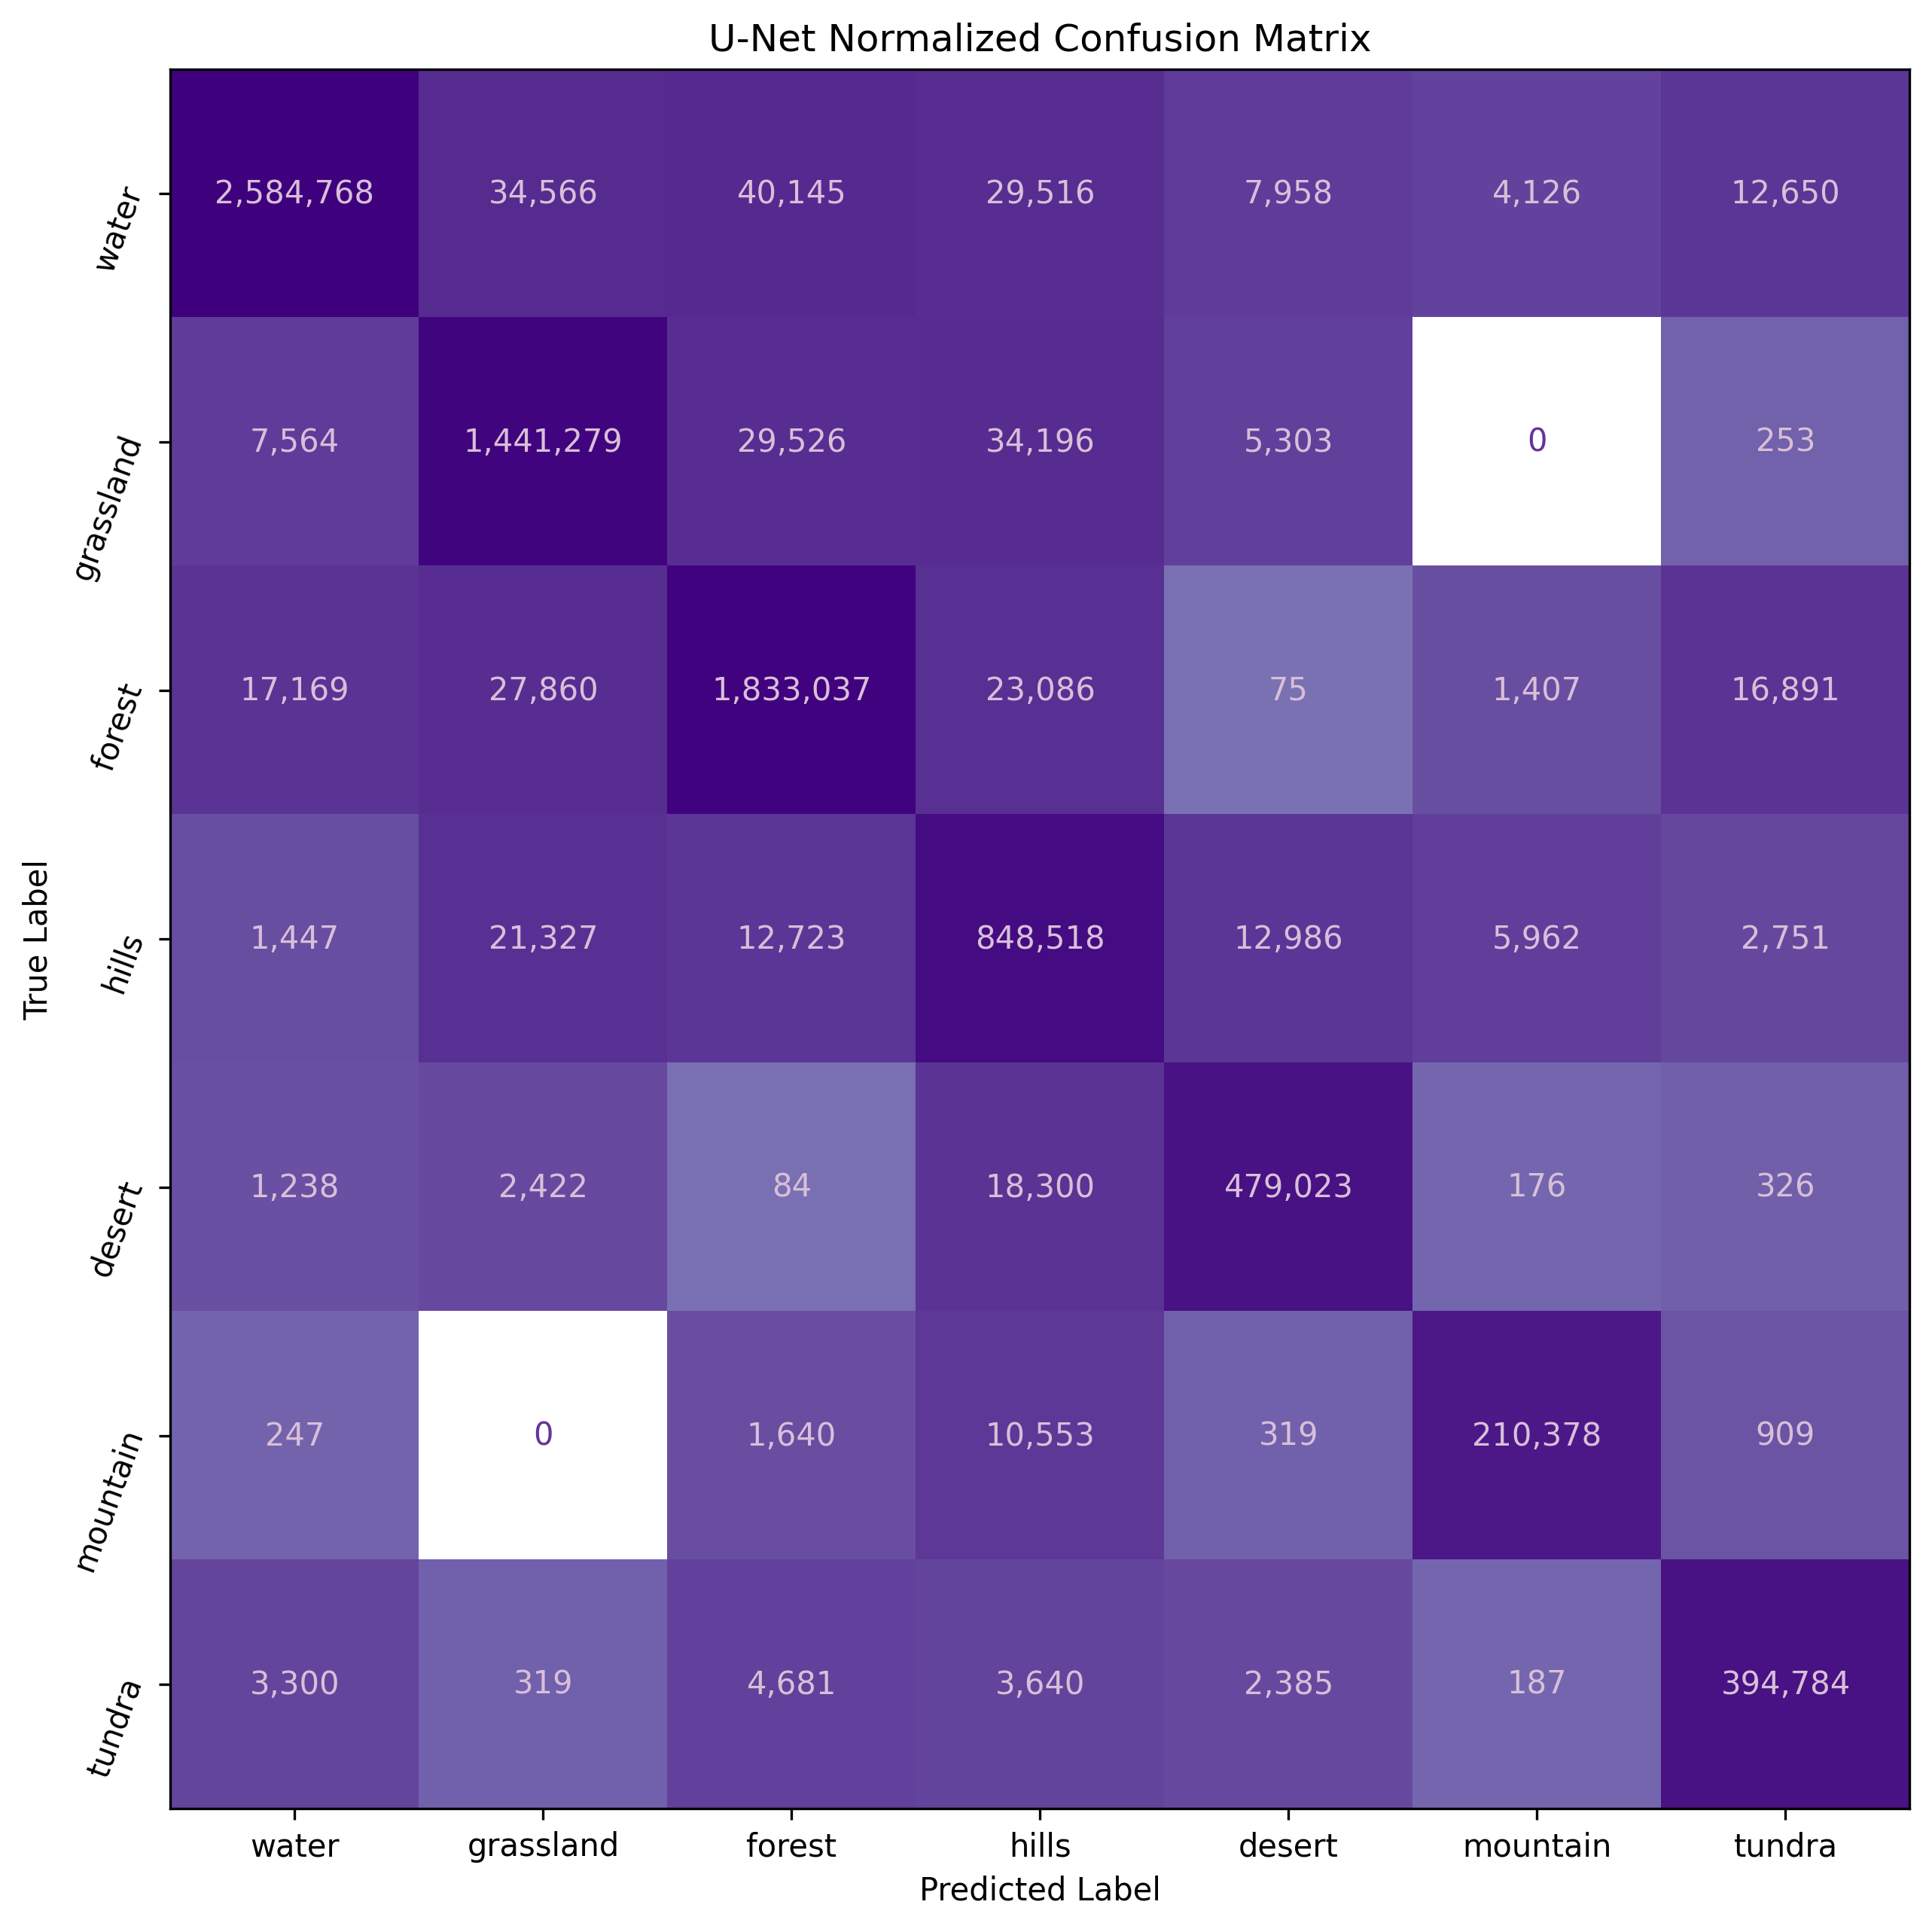

In [5]:

plt.figure(figsize=(10,10),dpi=300)
for example in test.take(1):
    # Get the true and predicted masks
    y_true = example[1]['conv2d_18']
    x = example[0]['input_1']

    y_true_flat = tf.reshape(y_true, (-1, 7))
    y_true_flat = tf.argmax(y_true_flat, axis=-1)
    
    y_pred_flat = tf.reshape(unet_pred, (-1, 7))
    y_pred_flat = tf.argmax(y_pred_flat, axis=-1)

    conf_matrix = tf.math.confusion_matrix(y_true_flat, y_pred_flat, num_classes=7)
    conf_matrix = np.array(conf_matrix)

    # Plot the confusion matrix heatmap
    plt.imshow(conf_matrix, cmap="Purples", norm=LogNorm(vmin=conf_matrix.min(), vmax=conf_matrix.max()))

# Add axis labels
plt.title('U-Net Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

class_labels = ['water', 'grassland', 'forest', 'hills', 'desert', 'mountain', 'tundra']
plt.xticks(range(7), class_labels)
plt.yticks(range(7), class_labels, rotation=70)

# Add annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f'{conf_matrix[i, j]:,}', ha='center', va='center', color="thistle" if conf_matrix[i, j] > 0.5 else "rebeccapurple")

plt.show()


## 2. Precision, Recall, and F1 Score
For the score calculation, we will use the default Keras implementations from <code>tf.keras.metrics</code>

In [6]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
f1 = tf.keras.metrics.F1Score()

# Reshape the true and predicted masks to have shape (500, 7)
y_true = tf.reshape(y_true, (-1, 7))
y_pred = tf.reshape(unet_pred, (-1, 7))

y_true_flat = tf.cast(y_true_flat, dtype=tf.float32)
y_pred_flat = tf.cast(y_pred_flat, dtype=tf.float32)

precision.update_state(y_true_flat, y_pred_flat)
recall.update_state(y_true_flat, y_pred_flat)
f1.update_state(y_true, y_pred)

print(f'Overall Precision: {precision.result().numpy()}')
print(f'Overall Recall: {recall.result().numpy()}')
print(f'F1 Score for each class: {f1.result().numpy()}')

# calculate precision, recall, and f1 by class
for i in range(7):
    precision.reset_states()
    recall.reset_states()

    y_true_flat_class = tf.cast(tf.equal(y_true_flat, i), dtype=tf.float32)
    y_pred_flat_class = tf.cast(tf.equal(y_pred_flat, i), dtype=tf.float32)

    precision.update_state(y_true_flat_class, y_pred_flat_class)
    recall.update_state(y_true_flat_class, y_pred_flat_class)

    print(f'Class {i} Precision: {precision.result().numpy()}')
    print(f'Class {i} Recall: {recall.result().numpy()} \n')

Overall Precision: 0.9768732190132141
Overall Recall: 0.9943476915359497
F1 Score for each class: [0.9699921  0.94637495 0.95436853 0.9057994  0.94891924 0.94280297
 0.94236267]
Class 0 Precision: 0.9881620407104492
Class 0 Recall: 0.952478289604187 

Class 1 Precision: 0.9433855414390564
Class 1 Recall: 0.9493834972381592 

Class 2 Precision: 0.9537947177886963
Class 2 Recall: 0.9549430012702942 

Class 3 Precision: 0.8767411708831787
Class 3 Recall: 0.93684983253479 

Class 4 Precision: 0.9428676962852478
Class 4 Recall: 0.9550490379333496 

Class 5 Precision: 0.946642279624939
Class 5 Recall: 0.9389946460723877 

Class 6 Precision: 0.9211786389350891
Class 6 Recall: 0.9645439982414246 



## 3. Training and Validation Accuracy by Epoch
We get the model histories from the corresponding JSON files and plot the training hostory for the three models.

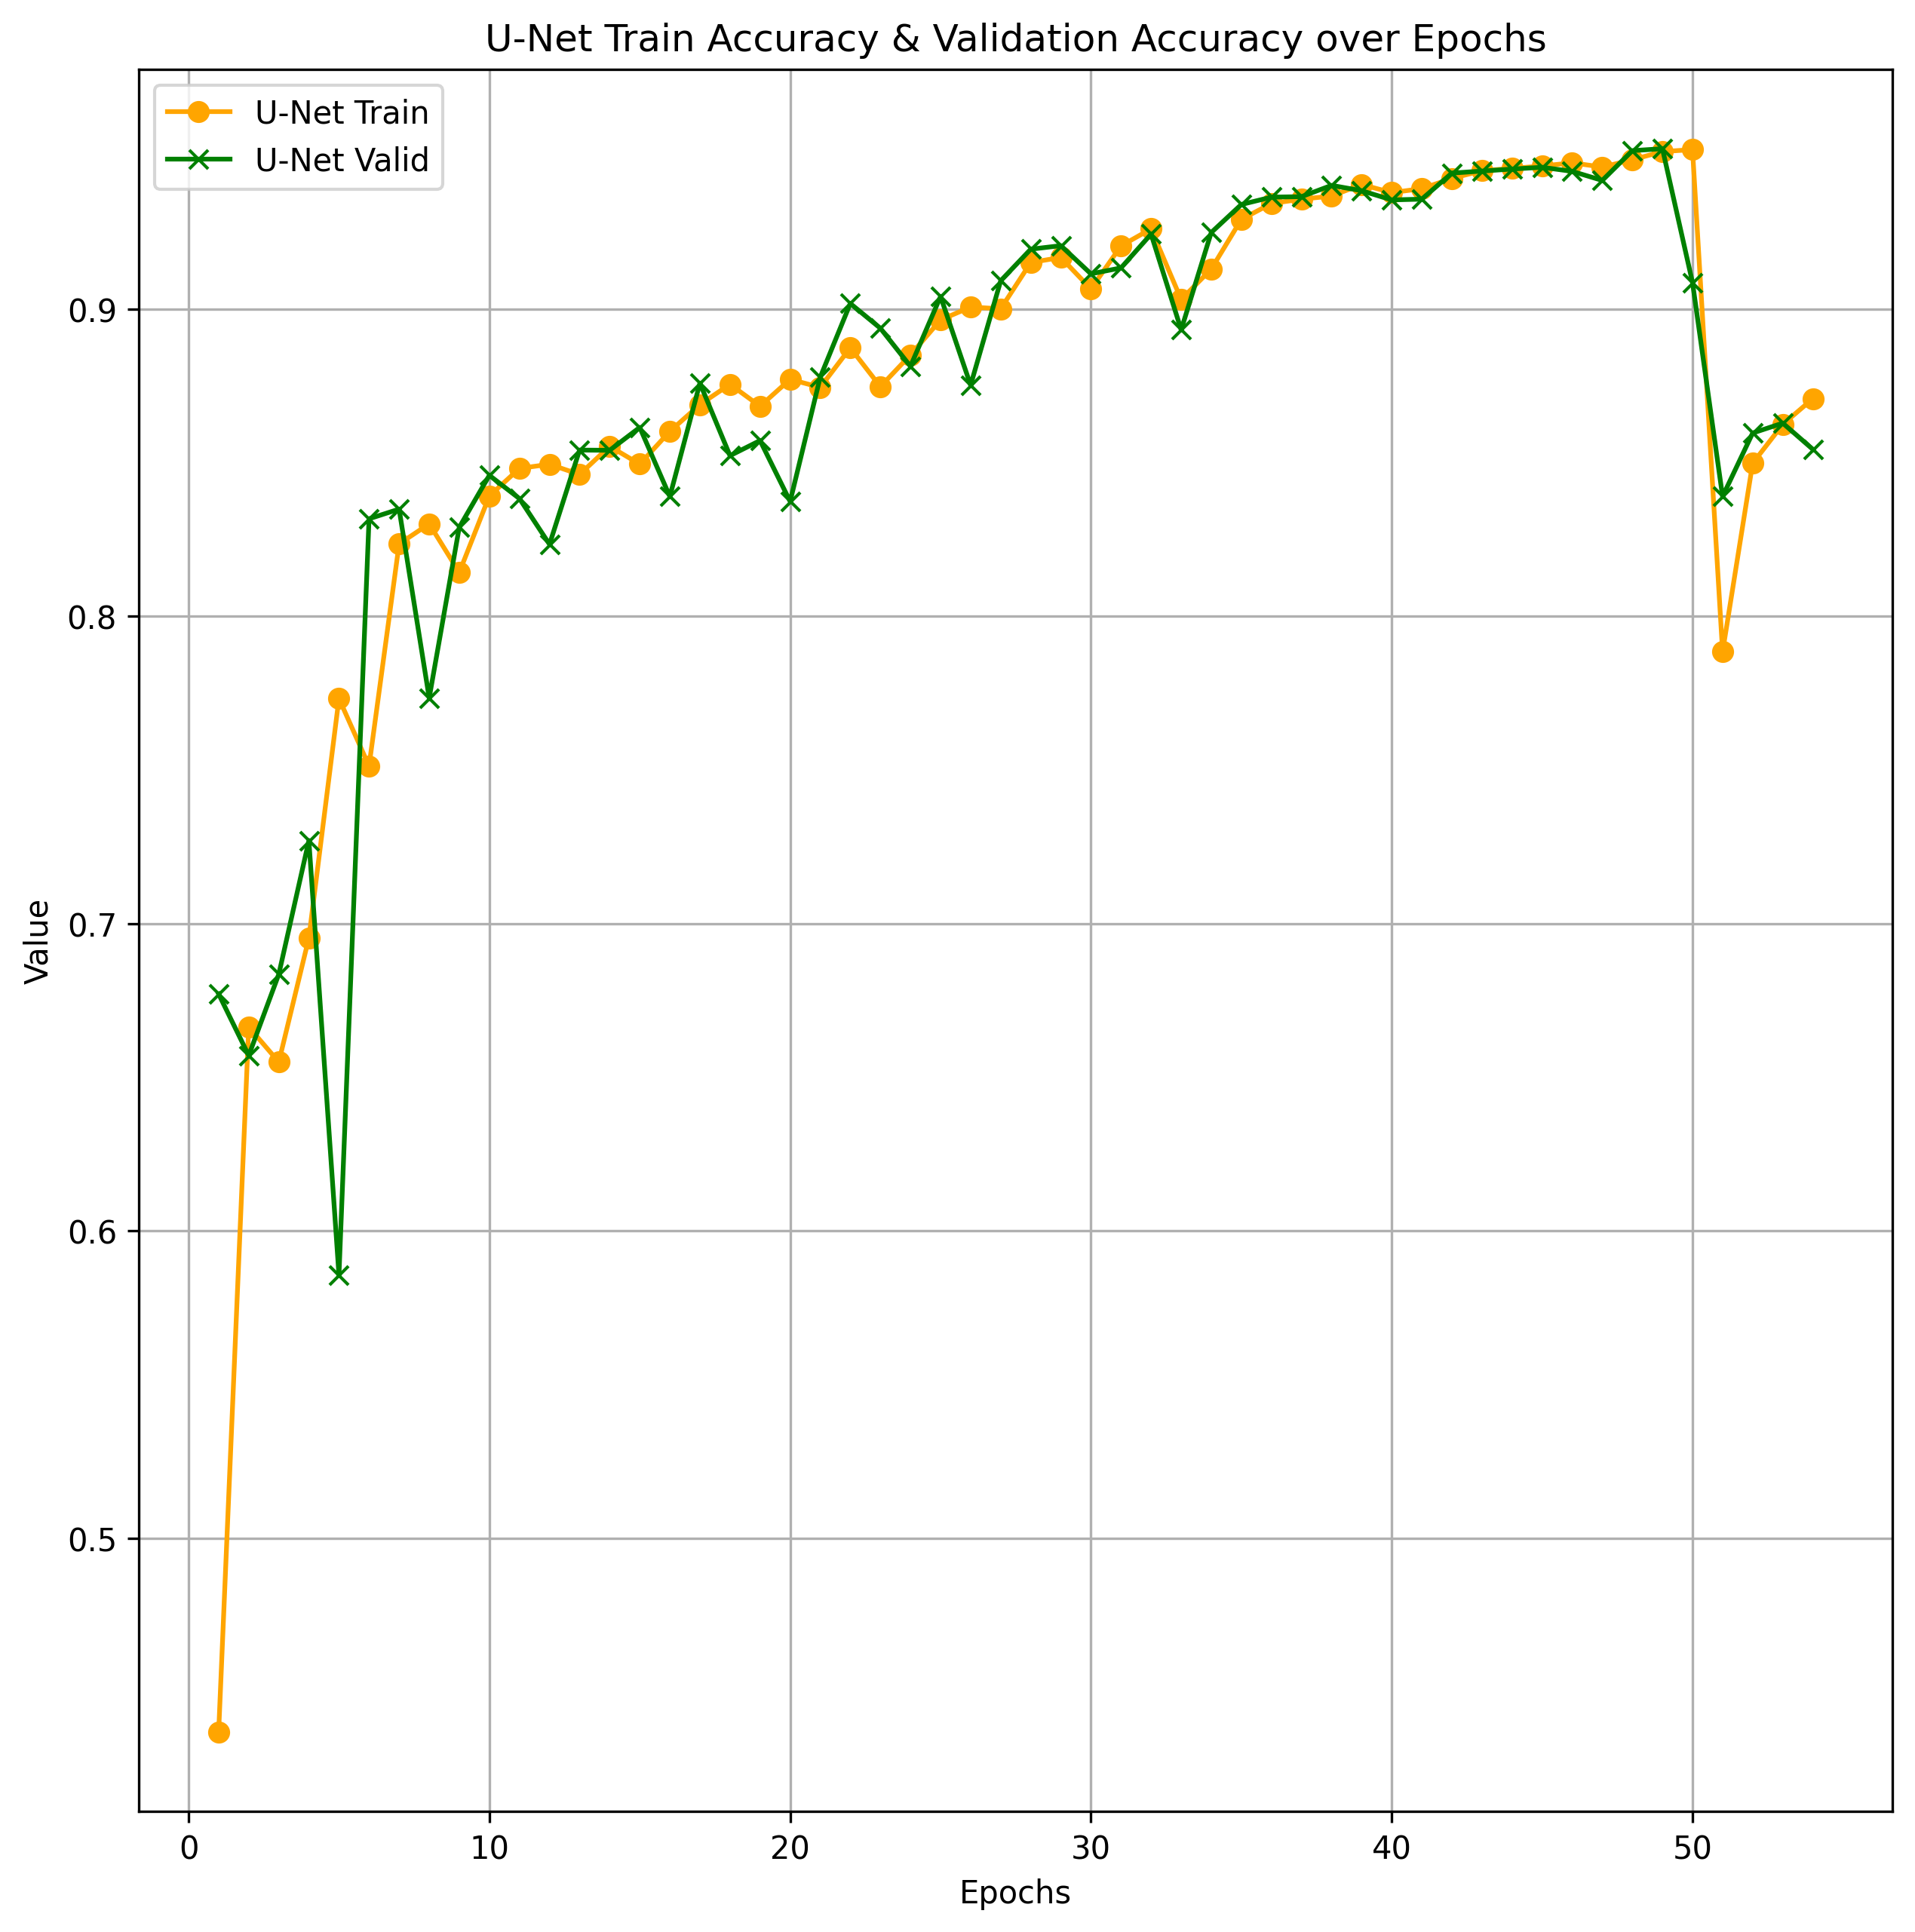

In [7]:
plt.figure(figsize=(10,10),dpi=300)

with open('../experiments/unet/model_hist_unet.json', 'r') as unet:
    unet_data = json.load(unet)
    x = list(range(1, 55))
with open('../experiments/fcn8/model_hist_fcn8.json', 'r') as fcn8:
    fcn8_data = json.load(fcn8)
    y = list(range(1, 8))
with open('../experiments/fcn32/model_hist_fcn32.json', 'r') as fcn32:
    fcn32_data = json.load(fcn32)
    z = list(range(1, 8))

plt.plot(x, unet_data["accuracy"], label='U-Net Train', marker='o', color='orange')
plt.plot(x, unet_data["val_accuracy"], label='U-Net Valid', marker='x', color='green')

plt.xlabel('Epochs')
plt.ylabel('Value')

plt.legend()
plt.title('U-Net Train Accuracy & Validation Accuracy over Epochs') #Accuracy
plt.grid(True)
plt.show()

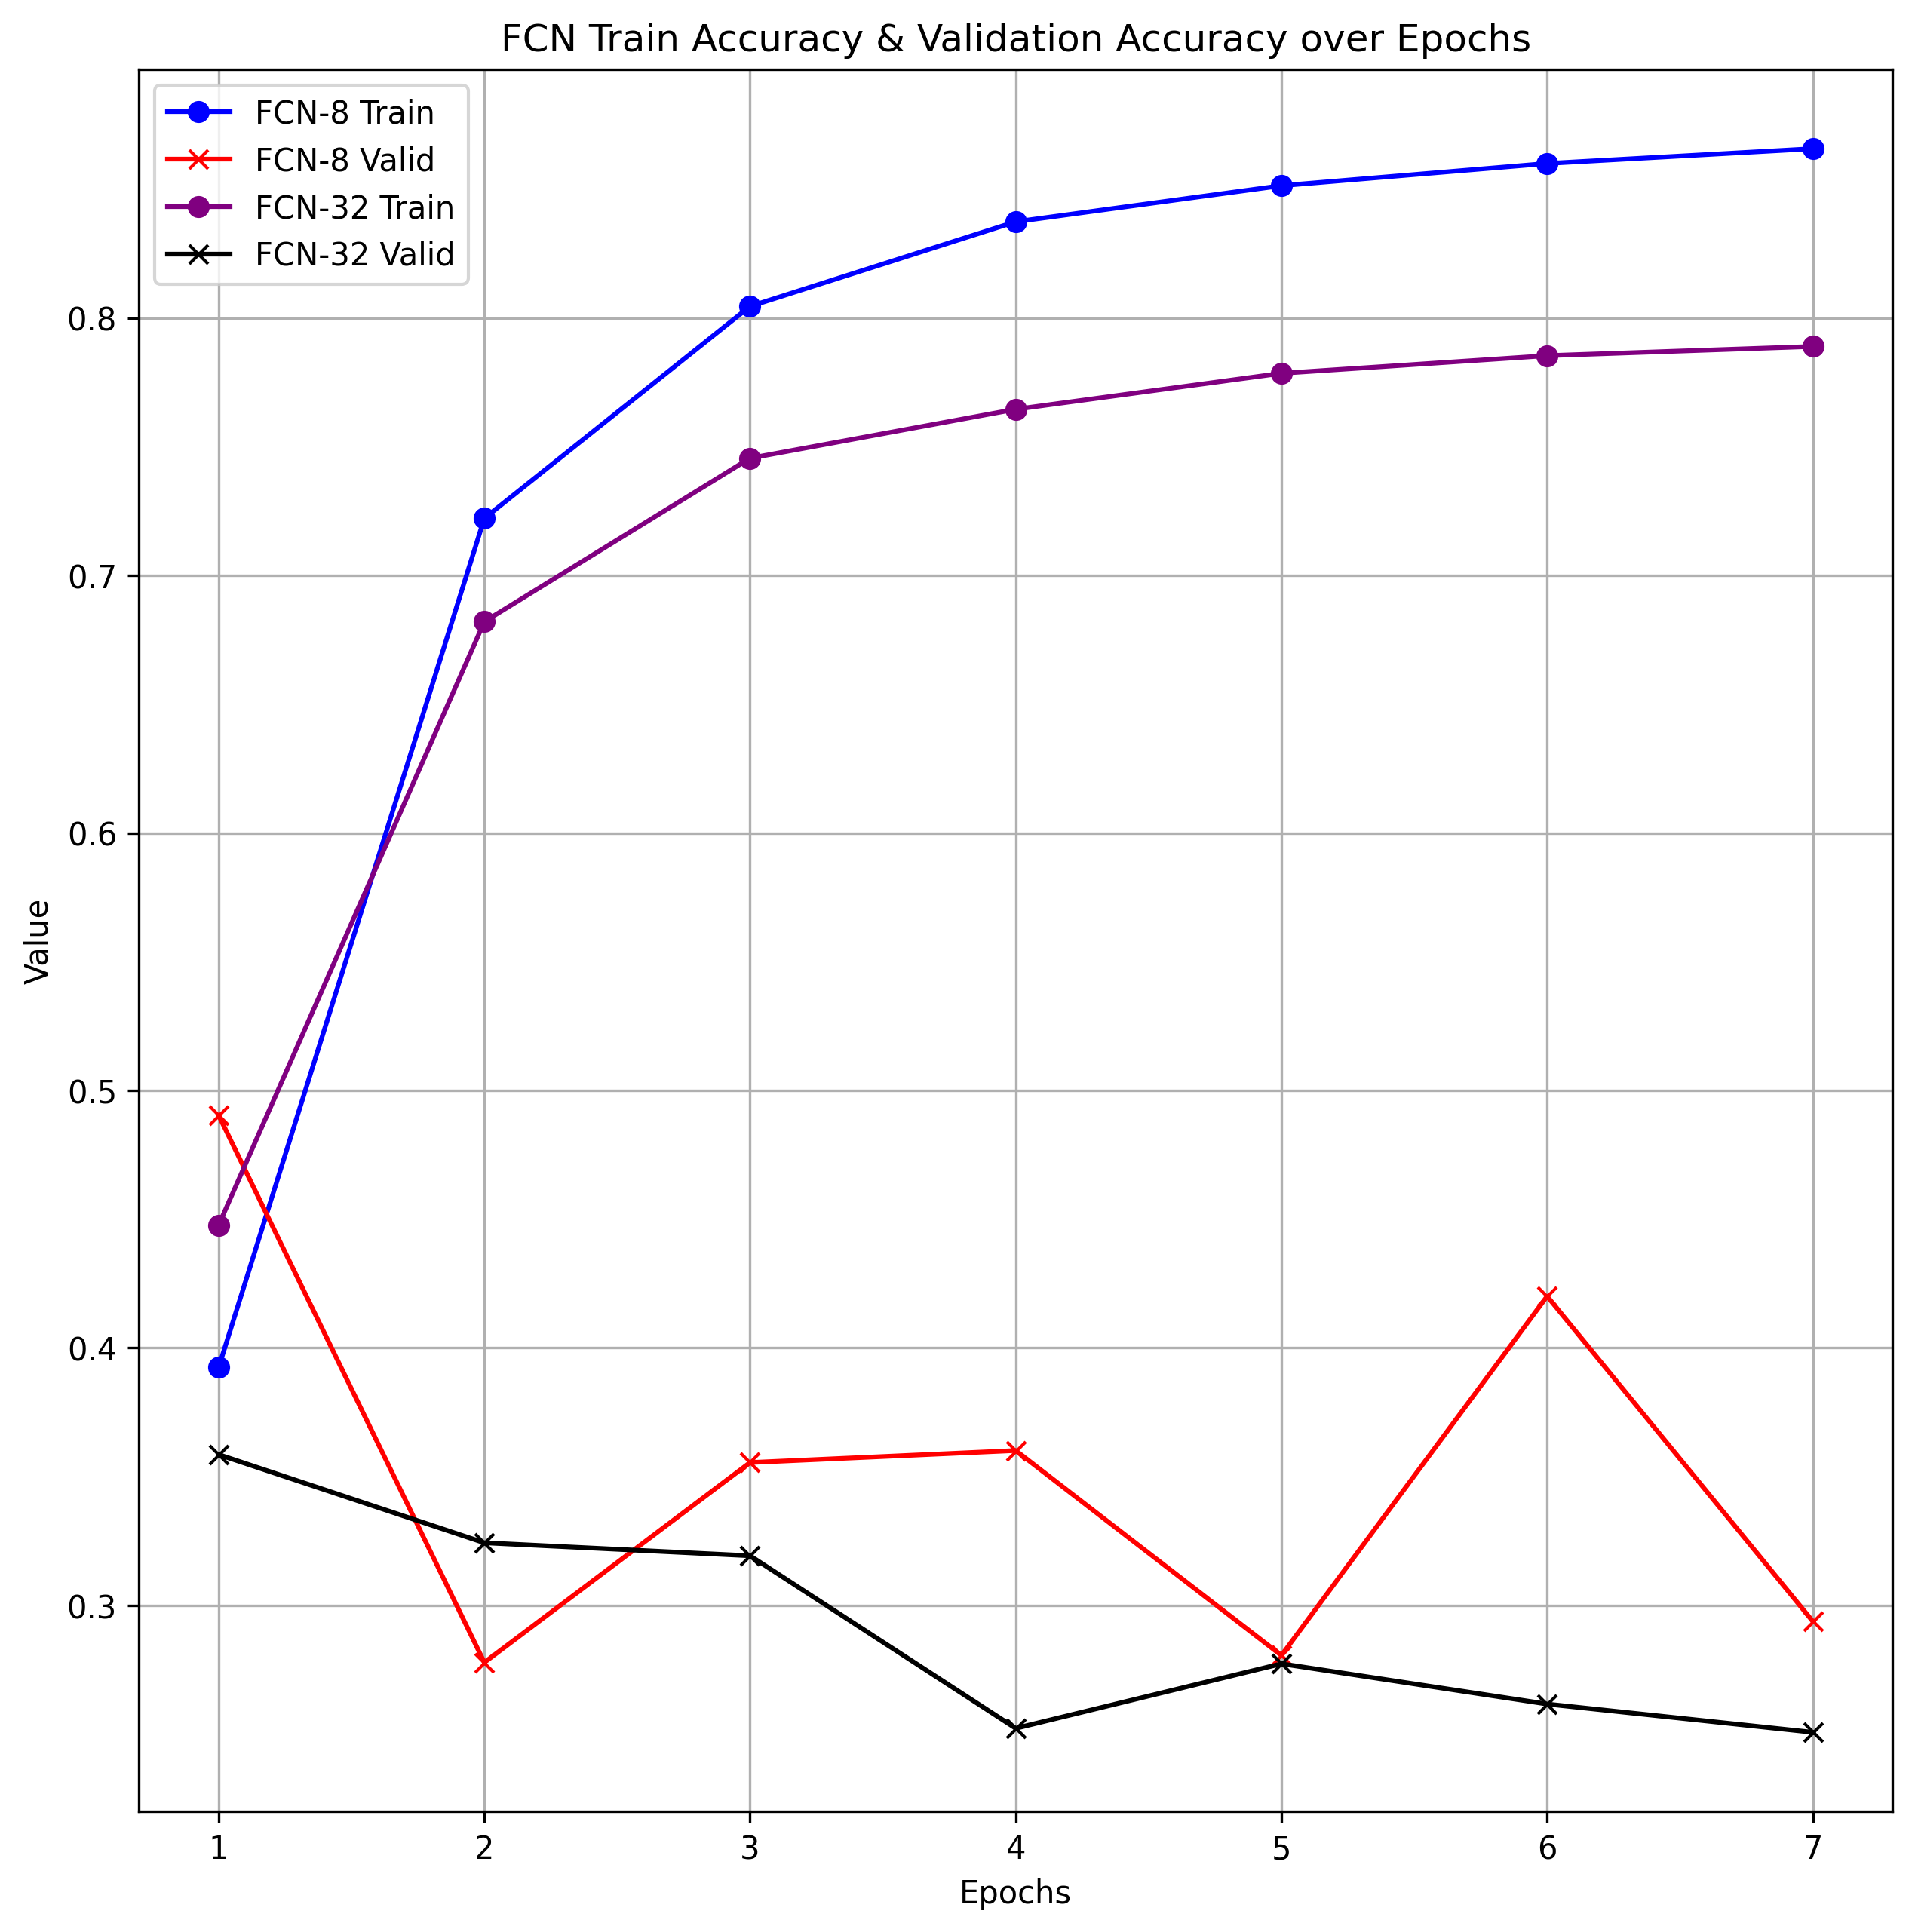

In [8]:
plt.figure(figsize=(10,10),dpi=300)
plt.plot(y, fcn8_data["accuracy"], label='FCN-8 Train', marker='o', color='blue')
plt.plot(y, fcn8_data["val_accuracy"], label='FCN-8 Valid', marker='x', color='red')
plt.plot(z, fcn32_data["accuracy"], label='FCN-32 Train', marker='o', color='purple')
plt.plot(z, fcn32_data["val_accuracy"], label='FCN-32 Valid', marker='x', color='black')

plt.xlabel('Epochs')
plt.ylabel('Value')

plt.legend()
plt.title('FCN Train Accuracy & Validation Accuracy over Epochs')
plt.grid(True)
plt.show()

## 4. U-Net Performance by Epoch
Now, we will generate the segmented outputs for the U-Net model using the saved check-point weights from training

In [ ]:
weight_file_names = ['unet_01-1.08.h5', 'unet_03-0.82.h5', 'unet_07-0.44.h5', 'unet_17-0.33.h5', 'unet_32-0.21.h5', 'unet_42-0.16.h5', 'unet_49-0.14.h5']

for name in weight_file_names:

    unet_model = Unet(7).build()
    unet_model.load_weights(f'../experiments/unet/weights/{name}')
    unet_pred = unet_model.predict(test)

    for example in test.take(1):
        # Get the true and predicted masks
        y_true = example[1]['conv2d_18']
        x = example[0]['input_1']

        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(unet_pred, axis=-1)

        for k in range(2):
            image_pred = np.zeros((128, 128, 3), dtype=np.uint8)
            for i in range(128):
                for j in range(128):
                    image_pred[i, j, 0] = CLASS_TO_COLOR[y_pred[k, i, j].numpy()][0]
                    image_pred[i, j, 1] = CLASS_TO_COLOR[y_pred[k, i, j].numpy()][1]
                    image_pred[i, j, 2] = CLASS_TO_COLOR[y_pred[k, i, j].numpy()][2]

            image_true = np.zeros((128, 128, 3), dtype=np.uint8)
            for i in range(128):
                for j in range(128):
                    image_true[i, j, 0] = CLASS_TO_COLOR[y_true[k, i, j].numpy()][0]
                    image_true[i, j, 1] = CLASS_TO_COLOR[y_true[k, i, j].numpy()][1]
                    image_true[i, j, 2] = CLASS_TO_COLOR[y_true[k, i, j].numpy()][2]
            
            raw_img = x[k].numpy()
            # Save the images
            epoch_name = name.split('-')[0].split('_')[1]
            if weight_file_names.index(name) == 0:
                #Adjust the encoding of the raw image
                plt.imshow(raw_img)
                plt.savefig(f'../img/unet_epochs/{epoch_name}_raw_{k}.png')
                plt.imshow(image_true)
                plt.savefig(f'../img/unet_epochs/{epoch_name}_true_{k}.png')
            plt.imshow(image_pred)
            plt.savefig(f'../img/unet_epochs/{epoch_name}_pred_{k}.png')


## 5. Get Example Predicted Images
We will get a few results from our inference for the report visualization

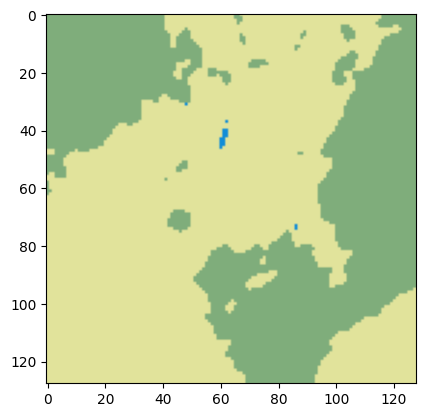

In [9]:
for example in test.take(3):
    # Get the true and predicted masks
    y_true = example[1]['conv2d_18']
    x = example[0]['input_1']

    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(unet_pred, axis=-1)

    for k in range(3):
        image_pred = np.zeros((128, 128, 3), dtype=np.uint8)
        for i in range(128):
            for j in range(128):
                image_pred[i, j, 0] = CLASS_TO_COLOR[y_pred[k, i, j].numpy()][0]
                image_pred[i, j, 1] = CLASS_TO_COLOR[y_pred[k, i, j].numpy()][1]
                image_pred[i, j, 2] = CLASS_TO_COLOR[y_pred[k, i, j].numpy()][2]

        plt.imshow(image_pred)
        plt.savefig(f'../img/unet_{k}.png')